In [17]:
import numpy as np
import pandas as pd
import pickle
import eli5
from   utils                   import *
from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.linear_model    import *
from   sklearn.ensemble        import *
from   sklearn.tree            import *
from   sklearn.svm             import LinearSVR
from   sklearn.metrics         import *
from   sklearn.model_selection import train_test_split
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from   sklearn.base            import BaseEstimator, TransformerMixin
from   sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from   sklearn.inspection      import permutation_importance

In [ ]:
! pip install streamlit

In [ ]:
! pip install eli5 category_encoders

# Research question:  
Can a linear or tree-based regression model be used to predict the number of bikes rented on a given day in London?

# Load data

In [19]:
bikes = pd.read_csv('london_merged.csv')
X = bikes.drop(['cnt'], axis=1)
y = np.ravel(bikes[['cnt']])

Text(0.5, 1.0, 'Histogram of Number of Bikes Rented')

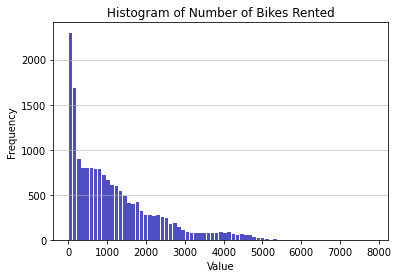

In [43]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=y, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Bikes Rented')

# Fit initial model
Fit a simple OLS linear regression with no feature engineering to serve as a baseline for target metrics. I will evaluate this model (and all models going forward) using R2, MAE, and RMSE. R2 gives a comparison to a baseline, "y-bar" regressor, MAE gives error in the same units as y, and RMSE is less sensitive to outliers. These are the most common metrics for regressors and together they give a broad interpretation of the model's performance.

In [20]:
X_init = X.drop(['timestamp'], axis=1)
X_train_init, X_validation_init, y_train_init, y_validation_init = train_test_split(X_init, y)
lm = LinearRegression()
lm.fit(X_train_init, y_train_init)
y_pred = lm.predict(X_validation_init)
mae = mean_absolute_error(y_validation_init, y_pred) #ground truth then predicted set
rmse = np.sqrt(mean_squared_error(y_validation_init, y_pred))
r2 = r2_score(y_validation_init, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")

MAE: 682.8344504062459, RMSE: 930.2214021305253, R2: 0.2558575290465701


With this baseline model, the error is pretty high -- for any given prediction, the model is almost 700 bikes off from the true number of bikes rented, and the model only accounts for about 25% of the variability in the target. From here I will perform feature engineering and iterative model selection to see how much I can improve performance using a basic sklearn regression model.

# Split data  
Split into train, validation and test splits using default sklearn 80-20 split. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=99)

# Model Selection 
I will split model selection into 2 sections, one for linear models and one for tree models. I'll test a handful of model and hyperparameter combinations in each category using RandomizedSearchCV, as it provides a decent set of candidates in much less time than grid search. I'll contain all data transformations within a Pipeline object so all transformations on train/val/test sets can be organized and streamlined. I've defined a few helper functions to aid in data transformation inside sklearn ColumnTransformers (see helpers.py). 

## Pipeline
Add all preprocessing steps to a pipeline object. The dataset is clean but I'll include a simple imputer on all steps for consistency and in case a manually supplied feature vector contains missing values. I'll use a custom Dummy Estimator as the last step in the pipeline so I can plug in different models during hyperparameter search. I'll use this same pipeline to test all candidate models.

In [22]:
# Pipeline for continuous data
con_pipe = Pipeline([('scaler', RobustScaler()),
                     ('imputer', SimpleImputer(strategy='median',
                                       add_indicator=True))])   

# Pipeline for categorical data
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('imputer', SimpleImputer(strategy='most_frequent',
                                       add_indicator=True))])  

# Split date column into hour, day of week, day of month, and month columns
# Returns 4 new columns @ position 0,1,2,3 in X np array 
clean_dates = ColumnTransformer([('split_time',  
                                  FunctionTransformer(split_dates, 
                                                      validate=False), 
                                    ['timestamp'])],
                                   sparse_threshold=0,remainder='passthrough') 

# Combine continuous and categorical steps
preprocessing = ColumnTransformer([('categorical', cat_pipe, [0,1,2,3,8,9,10,11]),
                                   ('continuous',  con_pipe, [4,5,6,7])],
                                   sparse_threshold=0,remainder='passthrough')

# Combine all steps and standardize the target to a normal distribution
transformer = QuantileTransformer(output_distribution='normal') # transform y
pipe = Pipeline([('clean_dates', clean_dates),
                 ('preprocessing', preprocessing),
                 ('lm',TransformedTargetRegressor(regressor=DummyEstimator(),
                                         transformer=transformer))])

## Linear Models  
Define a search space containing all of the linear models I want to try and a range of hyperparameters for each to run through. Pass it all into RandomizedSearchCV with my pipeline as the estimator. Fit the best model on X and y training sets.

In [23]:
# Create grid of candidate learning algorithms and their hyperparameters
search_space = [{'lm': [LinearRegression()]}, 
                
                {'lm': [Ridge()],  
                 'lm__alpha': [1e-6, 1e-3, .1, 1]}, # Regularization strength; constrains coeffs.
               
                {'lm': [BayesianRidge()], 
                 'lm__alpha_1': [1e-6, 1e-3, .1, 1], # Scale param for gamma dist prior over alpha.
                 'lm__alpha_2': [1e-6, 1e-3, .1, 1]}, # Shape param for gamma dist prior over alpha.
                
                {'lm': [SGDRegressor()],  
                 'lm__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 
                              'squared_epsilon_insensitive'], # Different variations on MSE to focus more/less on outliers/errors.
                 'lm__penalty': ['l2', 'l1', 'elasticnet'], # Type of regularization. Affects how many betas go to 0.
                 'lm__alpha': [1e-6, 1e-3, .1, 1]}  # Regularization strength; constrains coeffs.
               ]

# Good ol' random search
lm_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=25,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring=['r2','neg_mean_absolute_error', 
                                             'neg_root_mean_squared_error'],
                                    refit='r2',
                                    return_train_score=True)

#  Fit random search
best_linear_model = lm_algos_rand.fit(X_train, y_train)
results = lm_algos_rand.cv_results_

# View best model
best_linear_model.best_estimator_.get_params()['lm'], best_linear_model.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   34.0s finished


(Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 0.7105382112528562)

R2 has already significantly improved compared to baseline. I will now try the same feature space but with the new date columns treated as ordinal instead of one-hot-encoded.

## Try treating date columns as ordinal

In [24]:
# Pipeline for ordinal data (date columns)
ord_pipe = Pipeline([('enc', OrdinalEncoder()),
                     ('imputer', SimpleImputer(strategy='most_frequent',
                                       add_indicator=True))])  

# Add to preprocessing 
preprocessing = ColumnTransformer([('nominal', cat_pipe, [8,9,10,11]),
                                   ('continuous',  con_pipe, [4,5,6,7]),
                                   ('ordinal', ord_pipe, [0,1,2,3])],
                                   sparse_threshold=0,remainder='passthrough')
pipe = Pipeline([('clean_dates', clean_dates),
                 ('preprocessing', preprocessing),
                 ('lm',TransformedTargetRegressor(regressor=DummyEstimator(),
                                         transformer=transformer))])

# Refit
best_linear_model = lm_algos_rand.fit(X_train, y_train)
results = lm_algos_rand.cv_results_

# View best model
best_linear_model.best_estimator_.get_params()['lm'], best_linear_model.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   21.1s finished


(Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
       random_state=None, solver='auto', tol=0.001),
 0.7105382112528562)

R2 is about the same so I will keep this as the best model. 

## Validation scores of best linear model

In [25]:
y_pred = best_linear_model.predict(X_validation)
r2 = r2_score(y_validation, y_pred)
mae = mean_absolute_error(y_validation, y_pred)
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print(f"R2: {r2}, MAE: {mae}, RMSE: {rmse}")

R2: 0.7271373142383262, MAE: 401.89327100856076, RMSE: 576.8705350359055


Splitting up the time column significantly improved the model performance right off the bat.

## Tree Models  
Fit tree regression models and compare using same metrics (R2, MAE, RMSE).

In [27]:
# Same pipeline as before
pipe = Pipeline([('clean_dates', clean_dates),
                 ('preprocessing', preprocessing),
                 ('dt', DummyEstimator())])

# Handful of tree regressors and hyperparameter ranges
search_space = [{'dt': [DecisionTreeRegressor()],
                  'dt__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'], # Method of measuring purity per split.
                  'dt__max_depth': [3, 10, 20, None],  # Constrains height of tree. Higher = more complex tree, smaller leaves.
                  'dt__min_samples_leaf': [1,2,3,4,5]  # Constrains size of leaf nodes. Higher = less complex tree, large leaves.
                  },
                
                 {'dt': [RandomForestRegressor()],  
                  'dt__n_estimators': [100, 200, 300],
                  'dt__max_depth': [3, 10, 20, None],     # Constrains height of tree. Higher = more complex tree, smaller leaves.
                  'dt__min_samples_leaf': [1,2,3,4,5]},   # Constrains size of leaf nodes. Higher = less complex tree, large leaves.
               
                 {'dt': [AdaBoostRegressor()],
                  'dt__n_estimators': [50, 100, 200]},   # Number of decision trees. Higher = less noise, more computationally expensive.
                
                 {'dt': [GradientBoostingRegressor()], 
                  'dt__loss': ['ls', 'lad', 'huber', 'quantile'],  # Loss function to be optimized.
                  'dt__max_depth': [3, 10, 20, None],    # Constrains height of tree. Higher = more complex tree, smaller leaves.
                  'dt__min_samples_leaf': [1,2,3,4,5]},  # Constrains size of leaf nodes. Higher = less complex tree, large leaves.
                
                 {'dt': [StackingRegressor(estimators=[('lr', RidgeCV()),('svr', LinearSVR())],
                                            final_estimator=RandomForestRegressor(n_estimators=10))]}
               ]

# Plug everything into random search
dt_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=25,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1,
                                    scoring=['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                                    refit='r2',
                                    return_train_score=True)

# Fit best model on X and y training sets
best_tree_model = dt_algos_rand.fit(X_train, y_train);

# View best model
best_tree_model.best_estimator_.get_params()['dt'], best_tree_model.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  4.3min finished


(GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 0.9615908851007546)

## Validation scores of best tree model

In [28]:
y_pred = best_tree_model.predict(X_validation)
r2 = r2_score(y_validation, y_pred)
mae = mean_absolute_error(y_validation, y_pred)
rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
print(f"R2: {r2}, MAE: {mae}, RMSE: {rmse}")

R2: 0.9638082899763685, MAE: 111.23474727827363, RMSE: 210.09263786419288


This model yields the lowest errors and highest R2 yet. The model now accounts for about 95% of the variability in y and is only about 118 bikes off in prediction compared to almost 700 with the baseline OLS linear regression. I will choose this as my final model and use it to calculate test error.

# Final Model

In [ ]:
pipe = Pipeline([('clean_dates', clean_dates),
                 ('preprocessing', preprocessing),
                 ('dt',GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False))])

pipe.fit(X_train, y_train)

# Visual representation of pipeline and best model

In [30]:
pipe.steps

[('clean_dates',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0,
                    transformer_weights=None,
                    transformers=[('split_time',
                                   FunctionTransformer(accept_sparse=False,
                                                       check_inverse=True,
                                                       func=<function split_dates at 0x7fe7e91f5160>,
                                                       inv_kw_args=None,
                                                       inverse_func=None,
                                                       kw_args=None,
                                                       validate=False),
                                   ['timestamp'])],
                    verbose=False)),
 ('preprocessing',
  ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0,
                    transformer_weights=None,
                    transformers=[('n

## Test scores of final model

In [31]:
pipe.predict(X_test)
y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R2: {r2}, MAE: {mae}, RMSE: {rmse}")

R2: 0.964843647675953, MAE: 109.86228957299994, RMSE: 201.50038097098943


## Feature Importance

In [32]:
# Get names of one-hot-encoded categorical columns
onehot_cat_columns = list(pipe.named_steps['preprocessing']\
                          .named_transformers_['nominal']\
                          .named_steps['ohe']\
                          .get_feature_names(input_features=['weather_code','is_holiday','is_weekend', 'season']))

# Get names of one-hot-encoded ordinal columns
onehot_ord_columns = ['hour', 'dayofmonth', 'dayofweek', 'month']

# Names of numeric features 
numeric_features_list = ['t1', 't2', 'hum', 'wind_speed']

# Combine all feature names in the order the appear in the np array made by the pipeline
onehot_ord_columns.extend(numeric_features_list)
onehot_ord_columns.extend(onehot_cat_columns)

# Visualize feature importance
eli5.explain_weights(pipe.named_steps['dt'], top=50, feature_names=onehot_ord_columns)

Weight,Feature
0.7284 ± 0.4455,season_0.0
0.0570 ± 0.0610,is_holiday_0.0
0.0361 ± 0.0935,season_2.0
0.0329 ± 0.0811,is_holiday_1.0
0.0315 ± 0.1314,is_weekend_0.0
0.0266 ± 0.0270,weather_code_2.0
0.0166 ± 0.0335,weather_code_3.0
0.0127 ± 0.0184,t1
0.0116 ± 0.1433,season_1.0
0.0115 ± 0.0169,weather_code_1.0


# Final Model Interpretation
The final model that was chosen was a Gradient Boosting Regressor. Preprocessing and adding extra date columns significantly improved model performance from baseline. Overall the R2 of the model was around 0.96, indicating that around 96% of the variability in the target is explained by the regression tree. While running randomizedCV on the different tree algorithms helped to isolate the best algorithm to use, there didn't seem to be much variablity in performance within the Gradient Boosting Regressor in terms of hyperparameters. Overall the performance of the model was stable. 

The most important feature, with a significantly higher weight than all the other features, was dummy variable Season_0.0, aka Spring. This makes sense as Spring has long periods of daylight and mild temperatures in London where this data was collected. The next most important features were holiday=false and weekend=false, indicating that these bikes may be used for daily commutes to work. The second most influential season was Summer, which also makes sense for recreational outdoor bike riding.  
  
This model could be very helpful to bike rental companies as it provides a prediction of the number of bikes that will be rented on a given day at a given time. Rental companies could leverage these predictions to improve advertising efficiency or strategically increase/decrease numbers of available bikes based on circumstance.  
  
Future steps could include expanding the scope of the model to bike rentals outside London or incorporating exogenous variables such as information about individual customers and their rental habits. Additionally, one could build a time series model to map changes in cumulative bike rentals over time.

# Save model to pass into app.py

In [35]:
filename = 'finalized_model.sav'
pickle.dump(pipe, open(filename, 'wb'))